***Participantes (RM - NOME):***<br>
339624 - Camila<br>
339656 - Cleiton<br>
340214 - Henrique<br>
339708 - Roberto<br>
340192 - Sergio<br>

## **Criar um classificador de sentimento aplicando técnicas de PLN**
---

Utilizando o dataset de revisões de filmes em português [1], criar um classificador de sentimentos que consiga um score na métrica F1 Score superior a 70%.

Devem utilizar uma amostra de 20% e randon_state igual a 42 para testar as implementações e mensurar a métrica F1 Score (usar o parâmetro average = 'weighted') o restante dos dados devem ser utilizados para o treinamento (80%).

Fique a vontade para testar os métodos de pré-processamento, abordagens, algoritmos e bibliotecas, mas explique e justifique suas decisões.
O trabalho poderá ser feito em grupo de até 4 pessoas (mesmo grupo do Startup One).

Separe a implementação do seu modelo campeão junto com a parte de validação/teste de forma que o professor consiga executar todo o pipeline do modelo campeão.

Composição da nota:
- 50% - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, etc.)
- 50% - Baseado na performance obtida com o dataset de teste (conforme recomendação da amostra) no seu modelo campeão e na validação que o professor processar (Métrica F1 Score).

[1] - https://dados-ml-pln.s3-sa-east-1.amazonaws.com/reviews-pt-br.csv

# Bibliotecas utilizadas

In [4]:
import numpy as np
import pandas as pd
import spacy
import nltk
import seaborn as sb
import plotly.express as px


In [ ]:
df = pd.read_csv('./data/reviews-pt-br.csv', encoding='utf-8')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44514 entries, 0 to 44513
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   codigo      44514 non-null  int64 
 1   texto       44514 non-null  object
 2   sentimento  44514 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


Conferindo se temos dados nulos

In [4]:
df.isna().sum()

codigo        0
texto         0
sentimento    0
dtype: int64

In [5]:
df.head(10)

,codigo,texto,sentimento
0,1,Esse bocejo de pia de cozinha de orçamento mui...,neg
1,2,O Bravo parece indicar que o personagem princi...,neg
2,3,"Durante a Guerra pela Independência do Sul, GE...",pos
3,4,É fora de questão que a verdadeira Anna Anders...,pos
4,5,Concordo totalmente com outro dos revisores aq...,neg
5,6,Obra-prima absoluta de um filme! Boa noite Mr....,pos
6,7,Embora a palavra megalmania seja muito usada p...,pos
7,8,Esta tem que ser a peça mais incrível de porca...,neg
8,9,Eu suponho que todas as piadas internas são o ...,neg
9,10,"Se há um tema deste filme, é que as pessoas po...",pos


In [11]:
df.groupby('sentimento').count()

,codigo,texto
sentimento,,
neg,22307,22307
pos,22207,22207


<AxesSubplot:xlabel='sentimento', ylabel='count'>

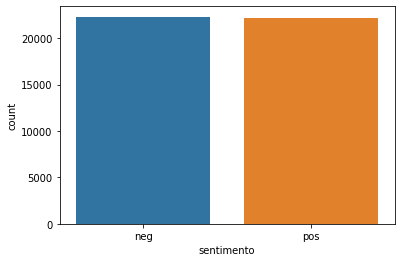

In [7]:
sb.countplot(x=df.sentimento)

####**Validação do professor**

Consolidar apenas os scripts do seu **modelo campeão**, desde o carregamento do dataframe, separação das amostras, tratamentos utilizados (funções, limpezas, etc.), criação dos objetos de vetorização dos textos e modelo treinado e outras implementações utilizadas no processo de desenvolvimento do modelo.

In [2]:
import plotly.express as px

fig = px.line(x=["a","b","c"], y=[1,3,2], title="sample figure")
#print(fig)
fig.show()